<a href="https://colab.research.google.com/github/lagonee23/price-prediction-models/blob/main/bitcoin_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암호화폐(BitCoin)의 가격 예측 모델


### 필요 모듈 설치
> [pyupbit](https://github.com/sharebook-kr/pyupbit) 모듈은 업비트라는 암호화폐 거래소의 API를 파이썬에서 쉽게 사용하기 위해 개발되었습니다.
해당 라이브러리를 통해 암호화폐의 현재 가격, 매매 주문 등의 정보를 쉽게 얻어올 수 있습니다.

In [2]:
!pip install pyupbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 5.4 MB/s eta 0:00:00


### 업비트에서 일봉(day)차트의 데이터 가져오기
* `open`: 시가
* `high`: 고가
* `low`: 저가
* `close`: 종가
* `volume`: 거래량
* `value`: 거래대금

> 업비트는 한국 거래소이므로 데이터의 단위는 원화(￦)입니다.

In [3]:
import pyupbit

# UpBit에서 비트코인 가격 데이터 가져오기
df_origin = pyupbit.get_ohlcv("KRW-BTC", "day", count=2500, period=1)
df_origin

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2023-12-07 09:00:00,60295000.0,60958000.0,58555000.0,59250000.0,8318.924757,4.969294e+11
2023-12-08 09:00:00,59237000.0,60753000.0,58750000.0,60142000.0,5252.133202,3.128890e+11
2023-12-09 09:00:00,60148000.0,60395000.0,59680000.0,60082000.0,3528.907593,2.121763e+11
2023-12-10 09:00:00,60082000.0,60277000.0,59563000.0,59835000.0,2575.294711,1.545037e+11


In [4]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2269 entries, 2017-09-25 09:00:00 to 2023-12-11 09:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2269 non-null   float64
 1   high    2269 non-null   float64
 2   low     2269 non-null   float64
 3   close   2269 non-null   float64
 4   volume  2269 non-null   float64
 5   value   2269 non-null   float64
dtypes: float64(6)
memory usage: 124.1 KB


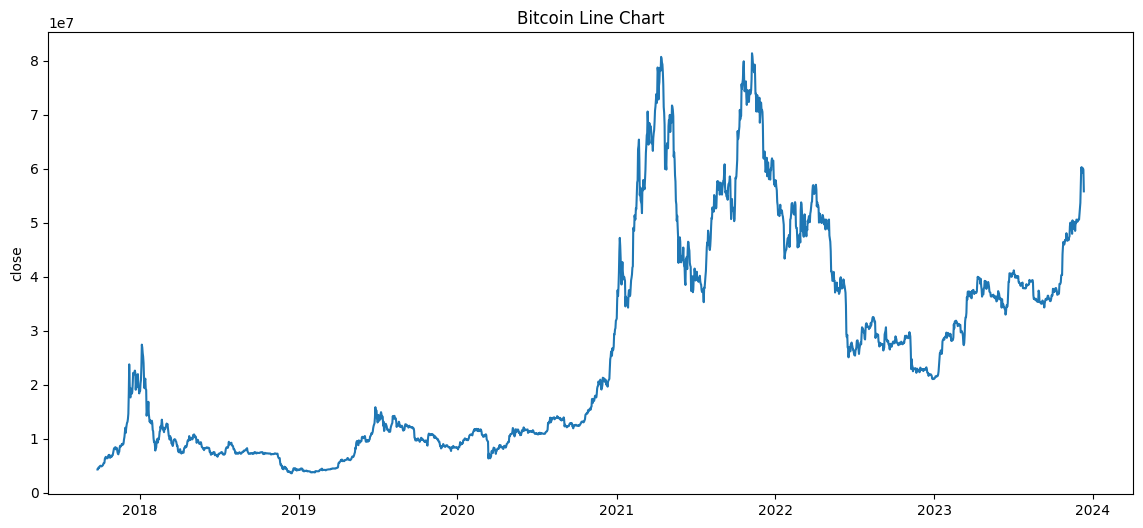

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_origin, x=df_origin.index, y='close')  # 비트코인 차트
plt.title('Bitcoin Line Chart');

## LSTM(Long Short Term Memory)
---
본 프로젝트에서는 long memory 특성을 보이는 비트코인의 가격 예측을 위한 딥러닝 모형으로 LSTM을 선택하였습니다. LSTM 모형을 이용하여 비트코인의 가격을 예측하고, 예측된 비트코인 가격을 이용한 이동평균선 교차 전략의 투자 성과를 비교 분석하겠습니다.

> [LSTM(Long Short-Term Memory)](https://wikidocs.net/152773) 모델은 순환 신경망(Recurrent Neural Network, RNN)의 한 종류로서, 시퀀스 데이터를 처리하는 데 효과적입니다. LSTM은 RNN의 장기 의존성 문제를 해결하기 위해 고안되었습니다.

### 1. 데이터 전처리
일별 수익률(`Return`) 컬럼을 추가합니다.

In [6]:
# 원본 복사
df = df_origin.copy()

df['Return'] = df['close'].pct_change()
df.head()

,open,high,low,close,volume,value,Return
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08,NaN
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07,-0.000231
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08,0.077760
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08,-0.015246
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,0.015482


`MinMaxScaler()` 최소/최대값이 각각 0, 1이 되도록 하여스 모든 feature 값이 0~1 사이에 있도록 데이터를 재조정합니다.

$$ Y = \frac{X-X_{min}}{X_{max}-X_{min}} $$



In [7]:
from sklearn.preprocessing import MinMaxScaler

# 입력 변수 설정
input_data = df[['open', 'high', 'low', 'close', 'Return']].values
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

print(input_data.shape)
input_data

(2269, 5)


array([[0.00746959, 0.00820097, 0.00802094, 0.00903785,        nan],
       [0.00896094, 0.00927672, 0.00980046, 0.00902499, 0.52942638],
       [0.00902522, 0.01255458, 0.00989205, 0.01334465, 0.65429073],
       ...,
       [0.72674912, 0.71771183, 0.73428852, 0.72589479, 0.52819959],
       [0.72590059, 0.71621844, 0.73275761, 0.72271933, 0.523215  ],
       [0.7227122 , 0.711675  , 0.67907098, 0.67124344, 0.42266169]])

학습 데이터는 전체 데이터의 70%로 합니다.

In [8]:
import math

# 학습용 데이터 설정
train_len = math.ceil(len(input_data) * 0.7)
train = input_data[0:train_len]
print("Train data shape:", train.shape)

Train data shape: (1589, 5)


연속된 5일의 데이터를 하나의 시퀀스로 설정하고 특성(features) 변수와 타겟(target) 변수를 분리합니다. 시퀀스를 설정하는 것이 시계열 패턴의 데이터를 학습하기에 용이합니다.

In [10]:
import numpy as np

# 시퀀스 설정
sequence_length = 5
X_train = []  # features
y_train = []  # target

for i in range(sequence_length, len(train)):
    X_train.append(train[i-sequence_length:i, :])
    y_train.append(train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1584, 5, 5)
y_train shape: (1584,)


In [11]:
X_train[0]

array([[0.00746959, 0.00820097, 0.00802094, 0.00903785,        nan],
       [0.00896094, 0.00927672, 0.00980046, 0.00902499, 0.52942638],
       [0.00902522, 0.01255458, 0.00989205, 0.01334465, 0.65429073],
       [0.01333213, 0.01375688, 0.01252208, 0.01243186, 0.50538808],
       [0.01241933, 0.01295956, 0.01195944, 0.01334465, 0.55458344]])

In [15]:
# 테스트 데이터 설정
test = input_data[train_len - sequence_length:]
test.shape
# x_test = []
# y_test = df['close'][train_data_len:].values

# for i in range(sequence_length, len(test_data)):
#     x_test.append(test_data[i-sequence_length:i, :])

# x_test = np.array(x_test)

(685, 5)

### 2. 모델 설정

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 5)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1),
])

# 모델 컴파일
adam = Adam(lr=0.01)
model.compile(optimizer=adam, loss='mean_squared_error')

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Features and target
X = df.drop('profit_loss', axis=1)
y = df['profit_loss']

# Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

> **기준 모델(Baseline Model)**은 예측 문제를 해결하기 위해 설정하는 단순한 모델이나 기준을 의미합니다. 이 모델은 일반적으로 복잡한 머신러닝 모델을 사용하기 전에, 문제를 얼마나 잘 이해하고 있는지, 어떤 방식으로 접근해야하는지를 판단하는 데 도움을 줍니다.

본 프로젝트에서는 타겟 변수의 **최빈값**으로 기준모델을 설정합니다.



In [ ]:
from sklearn.metrics import classification_report

for train_index, test_index in tscv.split(y):
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  base = y_train.mode()[0]  # 최빈값
  base_pred = [base] * len(y_test)

  # 성능 평가
  print('Base Model Report:')
  print(classification_report(y_test, base_pred))
  print('-'*53)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

for train_index, test_index in tscv.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # 성능 평가
  print('Logistic Regression Report:')
  print(classification_report(y_test, y_pred))
  print('-'*53)

### 데이터 정규화 및 기준모델의 정확도 계산

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Scaling
scaler_std = StandardScaler()

X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)


# 기준모델
base = y_train.mode()[0]
baseline = len(y_train) * [base]
y_pred_base = len(y_test) * [base]
# 기준모델의 정확도
print("Train accuracy:", accuracy_score(y_train, baseline).round(3))
print("Test accuracy:", accuracy_score(y_test, y_pred_base).round(3))

### 기준모델의 Confusion Matrix

In [ ]:
y_true0 = y_test.value_counts()[0]
y_true1 = y_test.value_counts()[1]
confusion_base = pd.DataFrame(index = ['True 0', 'True 1'], data = {'Predicted 0':[0,0], 'Predicted 1':[y_true0,y_true1]})
confusion_base

### 모델의 정확도

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

# 로지스틱 회귀
logCV_model = LogisticRegressionCV(cv=5)
logCV_model.fit(X_train_std, y_train)

# 로지스틱 회귀모델의 정확도
print("Train accuracy:", logCV_model.score(X_train_std, y_train).round(3))

### 평가지표

In [ ]:
from sklearn.metrics import classification_report

y_pred_test_log = logCV_model.predict(X_test_std)

print(classification_report(y_test, y_pred_test_log))